In [1]:
# mounting the google drive where the data csv files downloaded
from google.colab import drive
drive.mount('/gdrive')
%cd /gdrive

Mounted at /gdrive
/gdrive


In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import os,gc
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import roc_auc_score,roc_curve,auc,confusion_matrix
from sklearn.model_selection import RandomizedSearchCV
import xgboost as xgb
import time
plt.style.use('seaborn-whitegrid')
import warnings
warnings.simplefilter("ignore")
colors = [x['color'] for x in plt.rcParams['axes.prop_cycle']]
import itertools

In [3]:
train_data = pd.read_csv("/gdrive/My Drive/AIML/Project/train_combined.csv")
test_data = pd.read_csv("/gdrive/My Drive/AIML/Project/test_combined.csv")

In [4]:
red_col = ['D1', 'D10', 'D11', 'D13', 'D14', 'D15', 'D5', 'D6', 'V1', 'V104', 'V107', 'V108', 'V11', 'V111', 'V115', 'V117', 'V120', 'V121', 'V123', 'V124', 'V127', 'V129', 'V13', 'V130', 'V136', 'V138', 'V139', 'V14', 'V142', 'V147', 'V156', 'V160', 'V162', 'V165', 'V166', 'V169', 'V17', 'V171', 'V173', 'V175', 'V176', 'V178', 'V180', 'V182', 'V185', 'V187', 'V188', 'V198', 'V20', 'V203', 'V205', 'V207', 'V209', 'V210', 'V215', 'V218', 'V220', 'V221', 'V223', 'V224', 'V226', 'V228', 'V229', 'V23', 'V234', 'V235', 'V238', 'V240', 'V250', 'V252', 'V253', 'V257', 'V258', 'V26', 'V260', 'V261', 'V264', 'V266', 'V267', 'V27', 'V271', 'V274', 'V277', 'V281', 'V283', 'V284', 'V285', 'V286', 'V289', 'V291', 'V294', 'V296', 'V297', 'V3', 'V30', 'V301', 'V303', 'V305', 'V307', 'V309', 'V310', 'V314', 'V320', 'V325', 'V332', 'V335', 'V338', 'V36', 'V37', 'V4', 'V40', 'V41', 'V44', 'V47', 'V48', 'V54', 'V55', 'V56', 'V59', 'V6', 'V62', 'V65', 'V67', 'V68', 'V70', 'V76', 'V78', 'V8', 'V80', 'V82', 'V86', 'V88', 'V89', 'V91', 'V96', 'V98', 'V99']
# droping v cols 
drop_v_cols = [col for col in train_data.columns if col[0] == 'V' and col not in red_col]
drop_d_cols = [col for col in train_data.columns if col[0] == 'D' and len(col) <= 3 and col not in red_col]

drop_cols = []
drop_cols.extend(drop_v_cols)
#drop_cols.extend(drop_d_cols)

In [5]:
print(f'dropping {len(drop_cols)} columns')
train_data = train_data.drop(columns=drop_cols)
test_data = test_data.drop(columns=drop_cols)

dropping 210 columns


In [6]:
useful_cols = [col for col in train_data.columns if col not in ("isFraud","TransactionID_x", "TransactionID_y", "TransactionDT")]
print(len(useful_cols))

y_train = train_data['isFraud']
train_data = train_data.drop(columns='isFraud')
test_data.columns = [col for col in train_data.columns]
x_test = test_data[useful_cols].reset_index(drop=True)
x_train = train_data[useful_cols].reset_index(drop=True)

print(x_train.shape)
print(x_test.shape)
gc.collect()

221
(590540, 221)
(506691, 221)


0

In [7]:
category_cols = x_train.select_dtypes(include=['object']).columns
type_map = {c: str for c in category_cols}
x_train[category_cols] = x_train[category_cols].astype(type_map, copy=False)
x_test[category_cols] = x_test[category_cols].astype(type_map, copy=False)

for col in category_cols:
    # label encode all cat columns
    dff = pd.concat([x_train[col],x_test[col]])
    dff,_ = pd.factorize(dff,sort=True)
    if dff.max()>32000: 
        print(col,'needs int32 datatype')
           
    x_train[col] = dff[:len(x_train)].astype('int16')
    x_test[col] = dff[len(x_train):].astype('int16')
del dff

In [8]:
# Scaling numeric features
for col in useful_cols:
    if col not in category_cols:
        # min max scalar
        dff = pd.concat([x_train[col],x_test[col]])
        dff = (dff - dff.min())/(dff.max() - dff.min())
        dff.fillna(-1,inplace=True)

        x_train[col] = dff[:len(x_train)]
        x_test[col] = dff[len(x_train):]

del dff

print(f'fitting model on {len(useful_cols)} columns')
x_train.fillna(-1,inplace=True)
x_test.fillna(-1,inplace=True)

fitting model on 221 columns


In [9]:
idx = int(x_train.shape[0] * 0.8)
print(idx)

idx_tr = x_train.index[:idx]  
idx_val = x_train.index[idx:]

clf = xgb.XGBClassifier( 
        n_estimators=2000,
        max_depth=12, 
        learning_rate=0.02, 
        subsample=0.8,
        colsample_bytree=0.4, 
        missing=-1, 
        eval_metric='auc'
          )
model = clf.fit(x_train.loc[idx_tr,useful_cols], y_train[idx_tr], 
            eval_set=[(x_train.loc[idx_val,useful_cols],y_train[idx_val])],
            verbose=50, early_stopping_rounds=100)

472432
[0]	validation_0-auc:0.809738
Will train until validation_0-auc hasn't improved in 100 rounds.
[50]	validation_0-auc:0.867045
[100]	validation_0-auc:0.877142
[150]	validation_0-auc:0.886092
[200]	validation_0-auc:0.895024
[250]	validation_0-auc:0.902131
[300]	validation_0-auc:0.909136
[350]	validation_0-auc:0.913482
[400]	validation_0-auc:0.915766
[450]	validation_0-auc:0.916819
[500]	validation_0-auc:0.917764
[550]	validation_0-auc:0.917926
[600]	validation_0-auc:0.918281
[650]	validation_0-auc:0.918236
[700]	validation_0-auc:0.918388
[750]	validation_0-auc:0.918253
Stopping. Best iteration:
[681]	validation_0-auc:0.918468



In [10]:
def plot_confusion_matrix(y_actual, y_pred):
    #Get the confusion matrix, Precision & Re-call
    conf_matrix = confusion_matrix(y_actual, y_pred)
    recal_matrix =(((conf_matrix.T)/(conf_matrix.sum(axis=1))).T)        
    prec_matrix =(conf_matrix/conf_matrix.sum(axis=0))

    group_names = ['True Neg','False Pos','False Neg','True Pos']
    group_counts = ["{0:0.0f}".format(value) for value in
                    conf_matrix.flatten()]
    group_percentages = ["{0:.2%}".format(value) for value in
                        conf_matrix.flatten()/np.sum(conf_matrix)]
    labels = [f"{v1}\n{v2}\n{v3}" for v1, v2, v3 in
              zip(group_names,group_counts,group_percentages)]
    labels = np.asarray(labels).reshape(2,2)

    plt.figure(figsize=(20,4))
    plt.subplot(1, 3, 1)
    sns.heatmap(conf_matrix, annot=labels, fmt='', cmap='Blues')
    plt.xlabel('Predicted Class')
    plt.ylabel('Original Class')
    plt.title("Confusion matrix")

    plt.subplot(1, 3, 2)
    sns.heatmap(prec_matrix, annot=True, fmt='.3f', cmap='Blues')
    plt.xlabel('Predicted Class')
    plt.ylabel('Original Class')
    plt.title("Precision matrix")

    plt.subplot(1, 3, 3)
    sns.heatmap(recal_matrix, annot=True, fmt='.3f', cmap='Blues')
    plt.xlabel('Predicted Class')
    plt.ylabel('Original Class')
    plt.title("Recall matrix")

    plt.show()

Train ROC Score:  0.8759288760723968
Test ROC Score:  0.6760958636423515
Test confusion_matrix


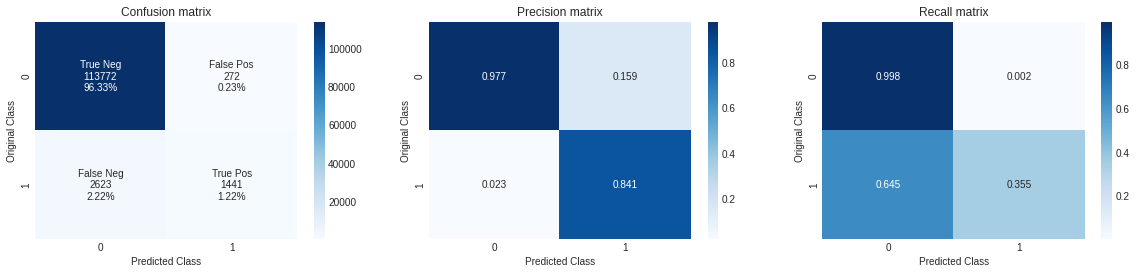

In [11]:
y_train_pred = model.predict(x_train.iloc[idx_tr])
y_test_pred = model.predict(x_train.iloc[idx_val])

y_train_act = y_train.iloc[idx_tr]
y_test_act = y_train.iloc[idx_val]

ROC_score = roc_auc_score(y_train_act, y_train_pred)
print('Train ROC Score: ', ROC_score)

ROC_score = roc_auc_score(y_test_act, y_test_pred)
print('Test ROC Score: ', ROC_score)

print('Test confusion_matrix')
plot_confusion_matrix(y_test_act, y_test_pred)

In [12]:
y_pred_test = model.predict_proba(x_test)[:,1]
submission = {}
submission.update(dict(zip(test_data['TransactionID_x'],y_pred_test)))
submission = pd.DataFrame.from_dict(submission, orient="index").reset_index()
submission.columns = ["TransactionID", "isFraud"]
submission.to_csv('/gdrive/My Drive/AIML/Project/submission1.csv',index=False)
submission.head()

,TransactionID,isFraud
0,3663549,0.002815
1,3663550,0.003153
2,3663551,0.002552
3,3663552,0.002069
4,3663553,0.002149
